# Retail Inventory Optimization and Forecasting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')
merged_data = pd.merge(train_data, store_data, on='Store', how='left')
merged_data.head()

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_12906/3222957641.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [2]:
merged_data.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [3]:
# Convert 'Date' to datetime and sort data
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.sort_values('Date', inplace=True)

# Handle missing values
merged_data['CompetitionDistance'].fillna(merged_data['CompetitionDistance'].median(), inplace=True)
merged_data['CompetitionOpenSinceMonth'].fillna(merged_data['CompetitionOpenSinceMonth'].median(), inplace=True)
merged_data['CompetitionOpenSinceYear'].fillna(merged_data['CompetitionOpenSinceYear'].median(), inplace=True)
merged_data['Promo2SinceWeek'].fillna(0, inplace=True)
merged_data['Promo2SinceYear'].fillna(0, inplace=True)
merged_data['PromoInterval'].fillna('Not Participating', inplace=True)

In [4]:
# Convert categorical columns
merged_data['StateHoliday'] = merged_data['StateHoliday'].astype('category')
merged_data['StoreType'] = merged_data['StoreType'].astype('category')
merged_data['Assortment'] = merged_data['Assortment'].astype('category')

# Check the structure and first few rows of the dataset
merged_data.info()
merged_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1017208 to 0
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  category      
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  category      
 10  Assortment                 1017209 non-null  category      
 11  CompetitionDistance        1017209 no

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,8.0,2010.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1016473,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,8.0,2010.0,0,0.0,0.0,Not Participating
1016472,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,0.0,0.0,Not Participating
1016471,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
1016470,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,0.0,0.0,Not Participating


## Exploratory Data Analysis (EDA)

### Univariate Analysis: Distribution of Key Variables

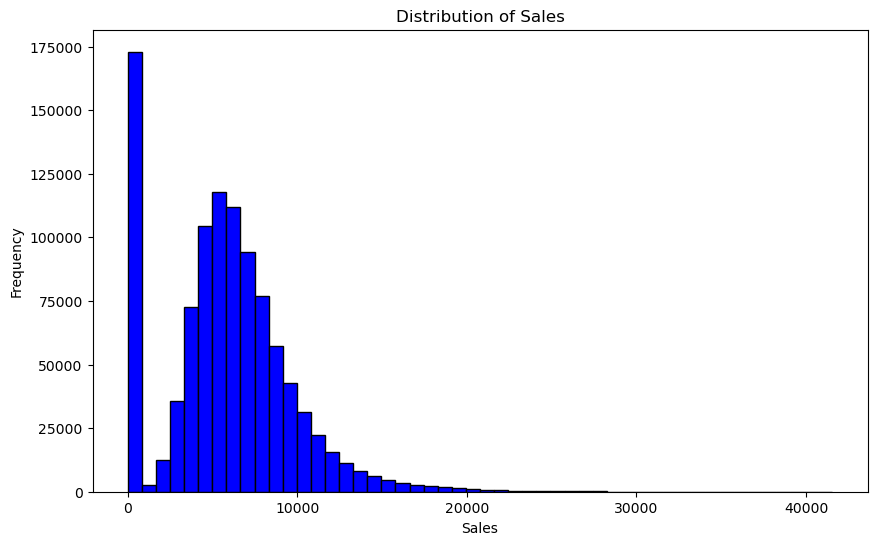

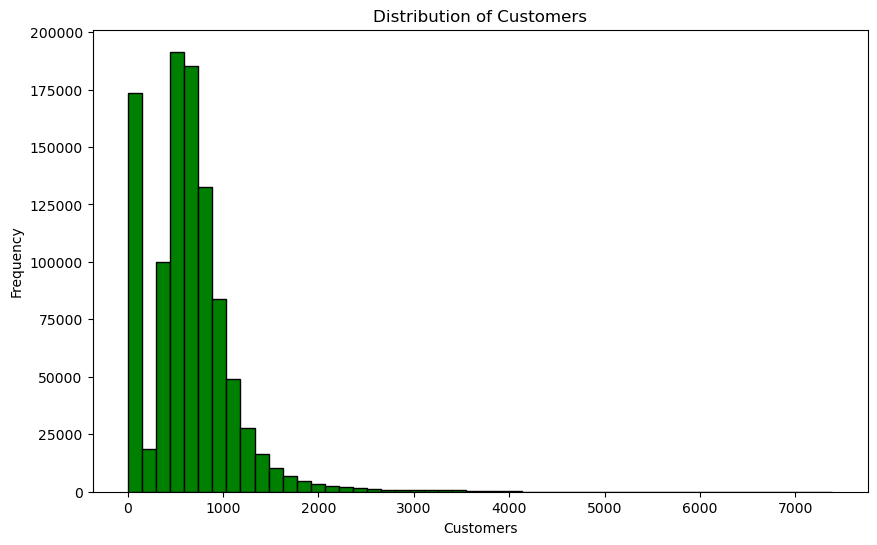

In [5]:
# Plotting distribution of Sales
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Sales'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Plotting distribution of Customers
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Customers'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Customers')
plt.xlabel('Customers')
plt.ylabel('Frequency')
plt.show()

### Bivariate Analysis

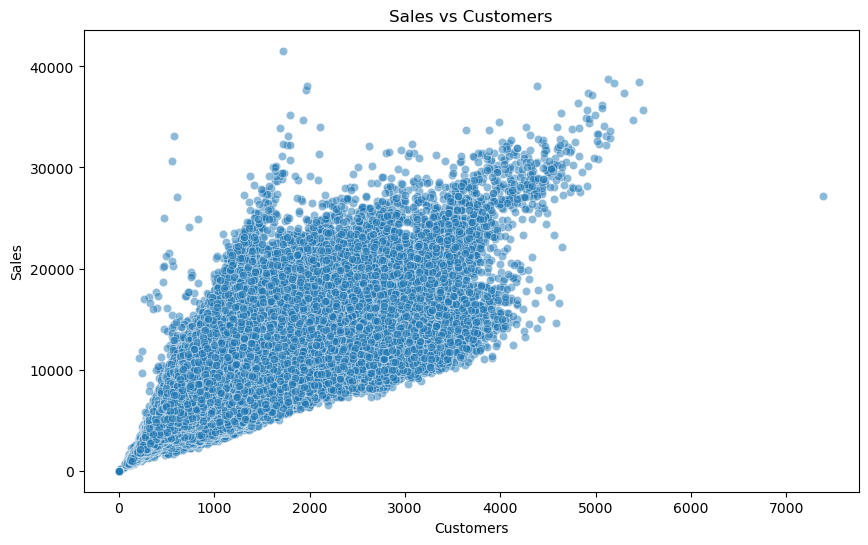

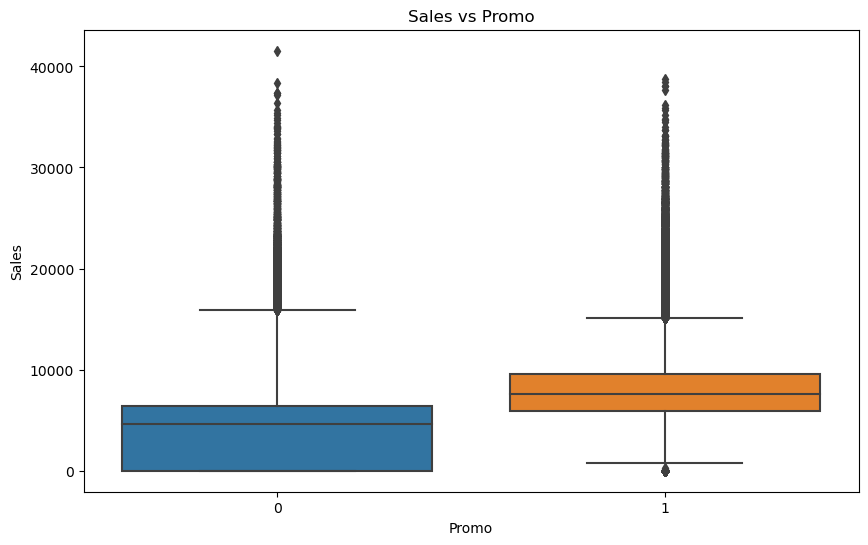

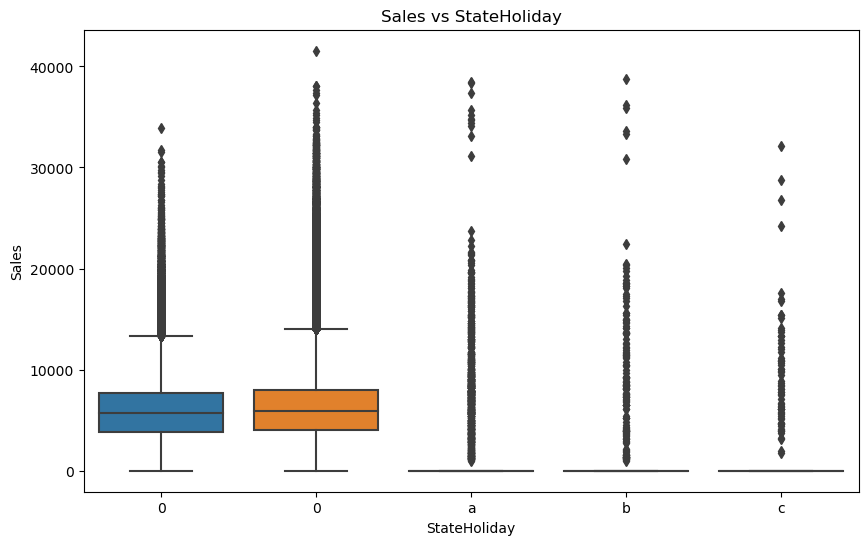

In [6]:
# Plotting Sales vs Customers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Customers', y='Sales', data=merged_data, alpha=0.5)
plt.title('Sales vs Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

# Analyzing effect of promotions on sales
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=merged_data)
plt.title('Sales vs Promo')
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.show()

# Analyzing effect of state holidays on sales
plt.figure(figsize=(10, 6))
sns.boxplot(x='StateHoliday', y='Sales', data=merged_data)
plt.title('Sales vs StateHoliday')
plt.xlabel('StateHoliday')
plt.ylabel('Sales')
plt.show()


### Time Series Analysis

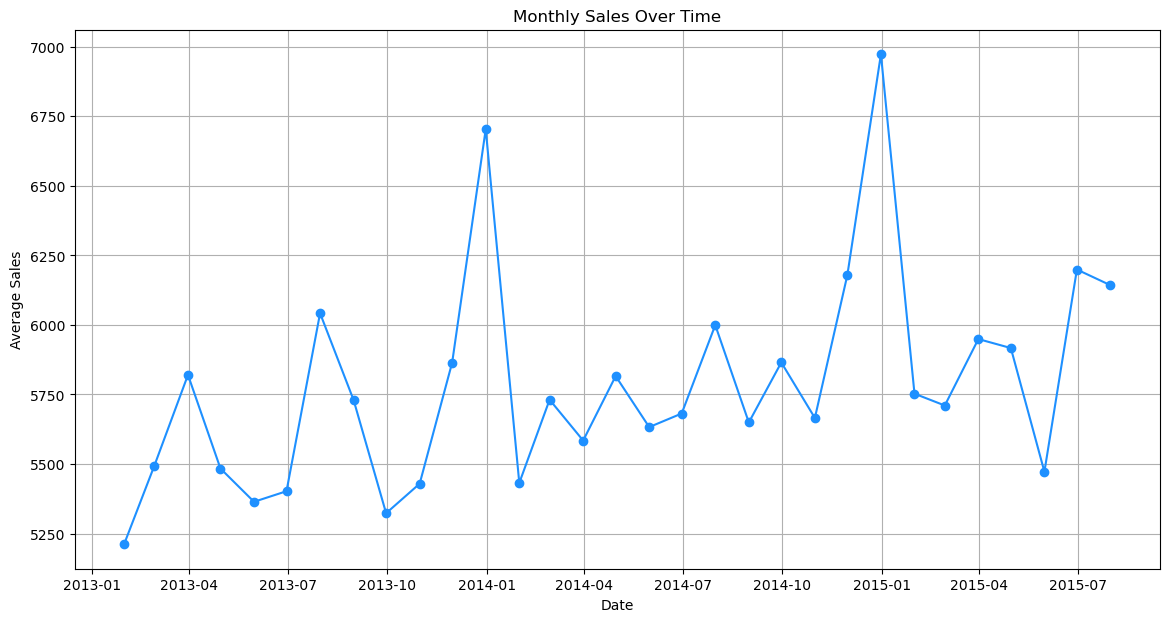

In [7]:
# Resampling sales data by month and plotting
monthly_sales = merged_data.set_index('Date')['Sales'].resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, color='dodgerblue', marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

### Time Series Decomposition

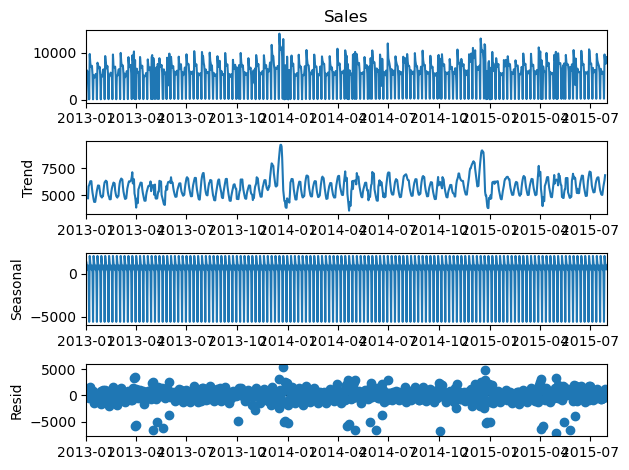

In [8]:
# Decompose the time series with weekly seasonality (period=7)
daily_sales = merged_data.set_index('Date')['Sales'].resample('D').mean().fillna(method='ffill')
result = seasonal_decompose(daily_sales, model='additive', period=7)

# Plot the decomposition
result.plot()
plt.show()

### Correlation Analysis

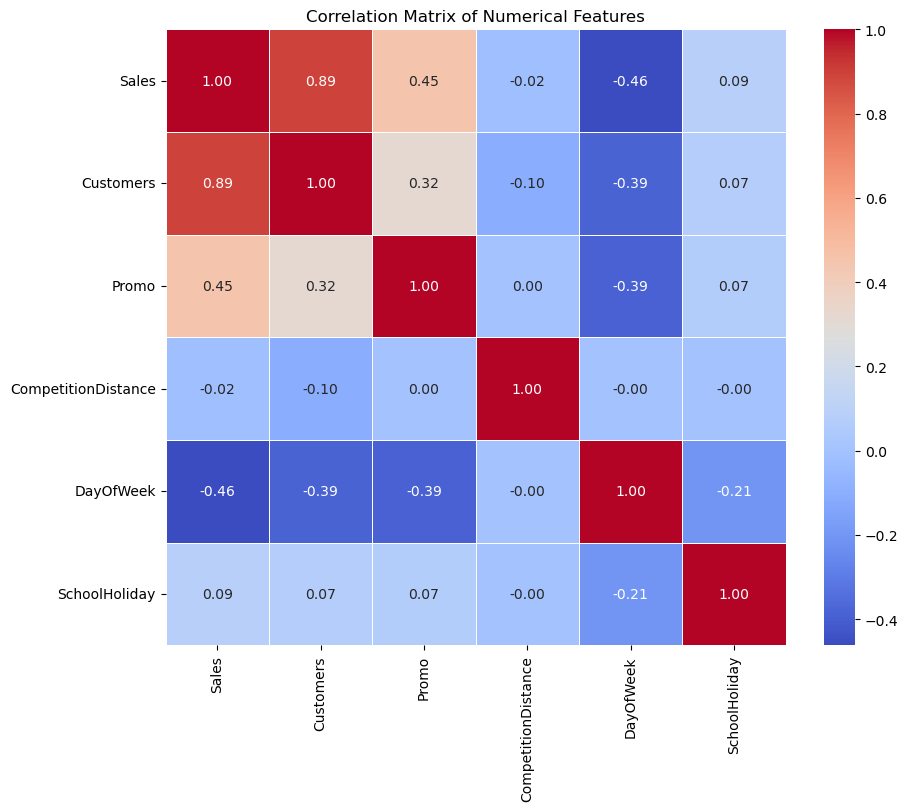

In [9]:
# Correlation matrix and heatmap for numerical features
correlation_matrix = merged_data[['Sales', 'Customers', 'Promo', 'CompetitionDistance', 'DayOfWeek', 'SchoolHoliday']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Promo Effect Over Time

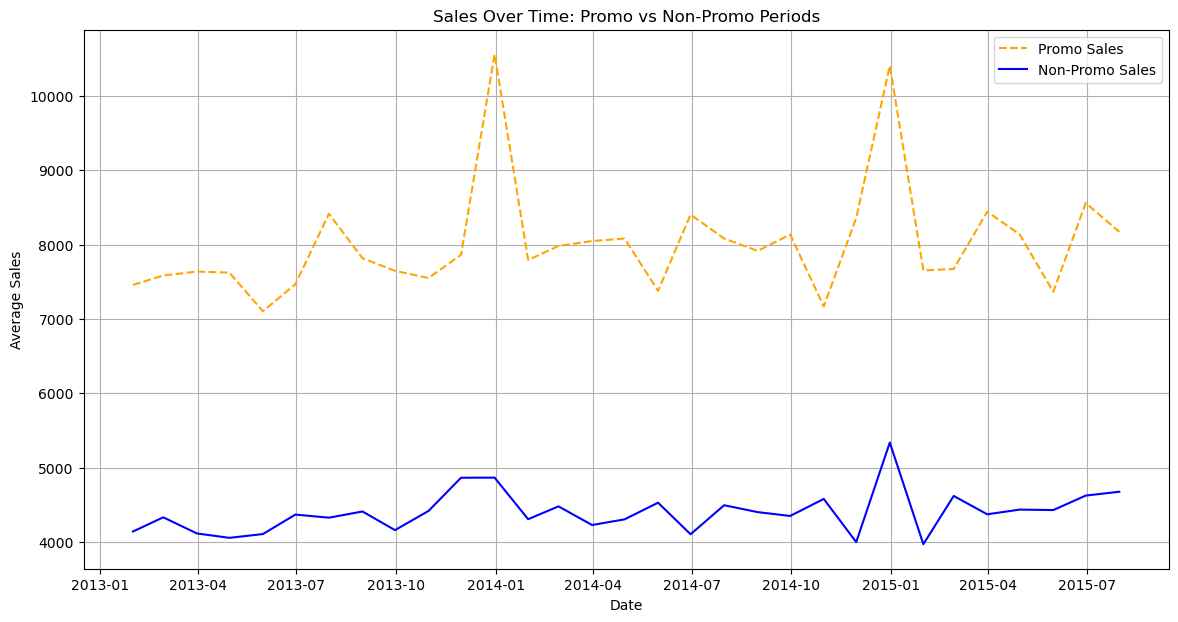

In [10]:
# Resample data by month for promo analysis
promo_sales = merged_data[merged_data['Promo'] == 1].set_index('Date').resample('M')['Sales'].mean()
non_promo_sales = merged_data[merged_data['Promo'] == 0].set_index('Date').resample('M')['Sales'].mean()

# Plot promo vs non-promo sales over time
plt.figure(figsize=(14, 7))
plt.plot(promo_sales.index, promo_sales, label='Promo Sales', color='orange', linestyle='--')
plt.plot(non_promo_sales.index, non_promo_sales, label='Non-Promo Sales', color='blue')
plt.title('Sales Over Time: Promo vs Non-Promo Periods')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

### Store Type and Assortment Analysis

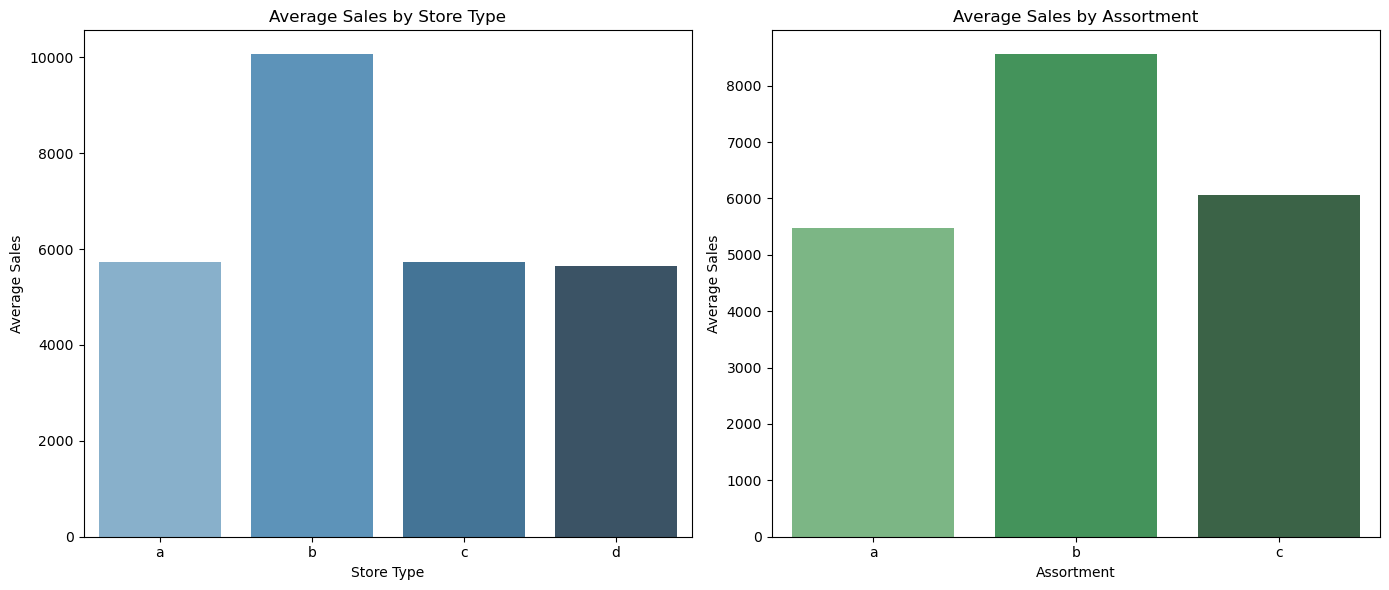

In [11]:
# Grouping the data by StoreType and calculating average sales
store_type_sales = merged_data.groupby('StoreType')['Sales'].mean()
assortment_sales = merged_data.groupby('Assortment')['Sales'].mean()

# Plotting StoreType vs Average Sales
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, palette="Blues_d")
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')

# Plotting Assortment vs Average Sales
plt.subplot(1, 2, 2)
sns.barplot(x=assortment_sales.index, y=assortment_sales.values, palette="Greens_d")
plt.title('Average Sales by Assortment')
plt.xlabel('Assortment')
plt.ylabel('Average Sales')

plt.tight_layout()
plt.show()

### Competition Impact on Sales

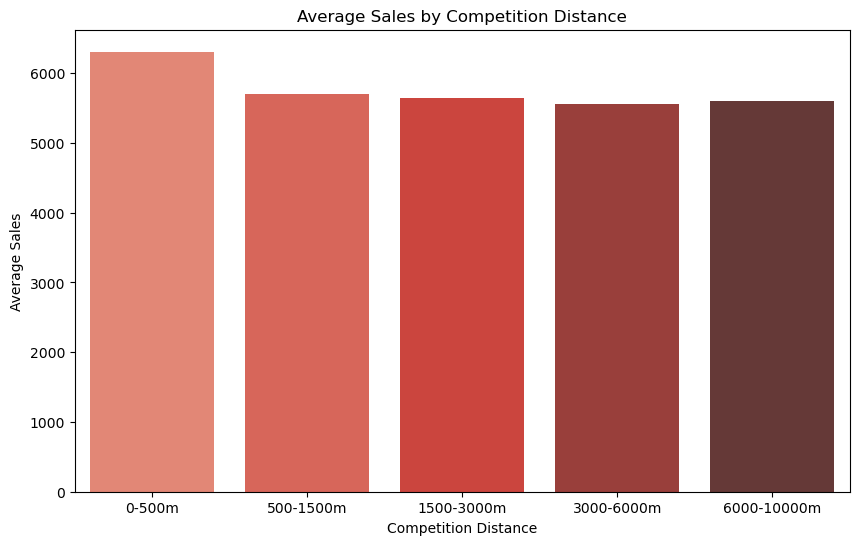

In [12]:
# Grouping the data into bins for CompetitionDistance
merged_data['CompetitionDistanceBins'] = pd.cut(merged_data['CompetitionDistance'], bins=[0, 500, 1500, 3000, 6000, 10000], 
                                                labels=['0-500m', '500-1500m', '1500-3000m', '3000-6000m', '6000-10000m'])

# Grouping by the CompetitionDistance bins and calculating average sales
comp_distance_sales = merged_data.groupby('CompetitionDistanceBins')['Sales'].mean()

# Plotting the impact of Competition Distance on Sales
plt.figure(figsize=(10, 6))
sns.barplot(x=comp_distance_sales.index, y=comp_distance_sales.values, palette='Reds_d')
plt.title('Average Sales by Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Average Sales')
plt.show()

### Sales Distribution by Day of the Week

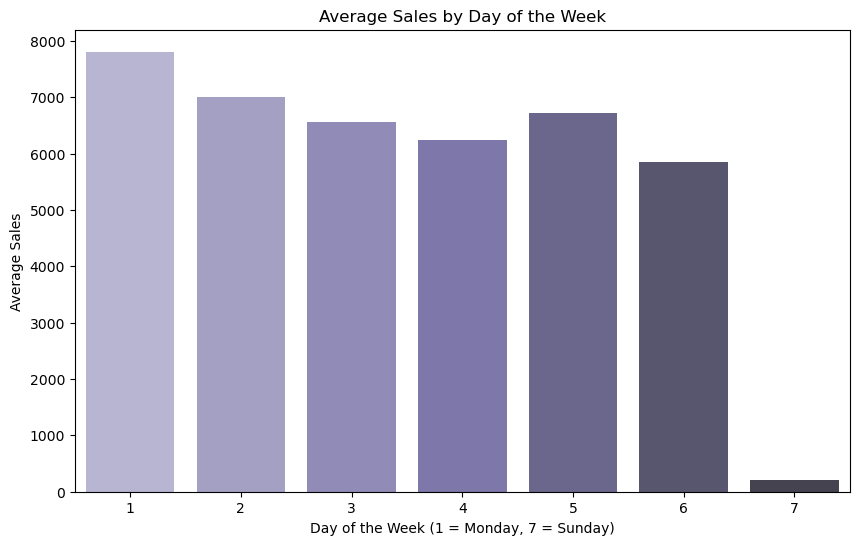

In [13]:
# Grouping data by DayOfWeek and calculating average sales
day_of_week_sales = merged_data.groupby('DayOfWeek')['Sales'].mean()

# Plotting sales distribution by Day of the Week
plt.figure(figsize=(10, 6))
sns.barplot(x=day_of_week_sales.index, y=day_of_week_sales.values, palette="Purples_d")
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week (1 = Monday, 7 = Sunday)')
plt.ylabel('Average Sales')
plt.show()

### Seasonal Trends Across Years

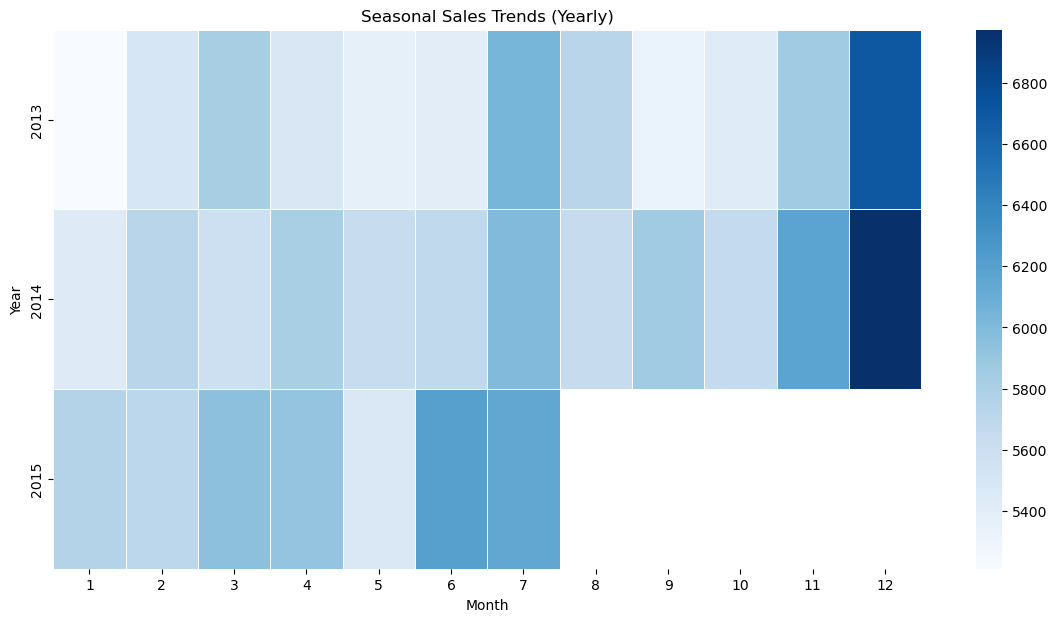

In [14]:
# Extracting year and month for better seasonal analysis
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month

# Grouping sales data by year and month
yearly_sales = merged_data.groupby(['Year', 'Month'])['Sales'].mean().unstack()

# Plotting seasonal sales trends across different years
plt.figure(figsize=(14, 7))
sns.heatmap(yearly_sales, cmap='Blues', annot=False, linewidths=0.5)
plt.title('Seasonal Sales Trends (Yearly)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

## Feature Engineering

In [15]:
# Adding time-related features
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Year'] = merged_data['Date'].dt.year

# Creating interaction term for Promo and SchoolHoliday
merged_data['Promo_SchoolHoliday'] = merged_data['Promo'] * merged_data['SchoolHoliday']

# Select features for modeling
features = ['Customers', 'Promo', 'DayOfWeek', 'SchoolHoliday', 'CompetitionDistance', 'Month', 'Year', 'Promo_SchoolHoliday']
target = 'Sales'

# Prepare data for modeling
X = merged_data[features].fillna(0)
y = merged_data[target]

## Machine Learning: Sales Forecasting

### Baseline Linear Regression

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = linear_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Linear Model MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


Linear Model MAE: 1057.3785898659116, RMSE: 1524.769504672281, R-squared: 0.8428804693271568


## Random Forest Model

In [17]:
# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model MAE: {mae_rf}, RMSE: {rmse_rf}, R-squared: {r2_rf}")

Random Forest Model MAE: 425.5754197042705, RMSE: 723.9098735928858, R-squared: 0.9645847119562025


## Inventory Optimization Calculations

### Economic Order Quantity (EOQ)

In [18]:
# Parameters for EOQ calculation
D = merged_data['Sales'].mean() * 30  # Monthly demand
S = 50  # Ordering cost per order
H = 2  # Holding cost per unit per month

# EOQ formula
EOQ = np.sqrt((2 * D * S) / H)
print(f"Economic Order Quantity (EOQ): {EOQ}")

Economic Order Quantity (EOQ): 2942.9115614401985


### Safety Stock and Reorder Point (ROP)

In [19]:
# Safety Stock calculation
Z = 1.96  # Z-score for 95% service level
sigma_d = merged_data['Sales'].std()  # Standard deviation of sales
LT = 5  # Lead time in days

# Calculate Safety Stock
Safety_Stock = Z * sigma_d * np.sqrt(LT)
print(f"Safety Stock: {Safety_Stock}")

# Calculate Reorder Point
ROP = (D * LT) + Safety_Stock
print(f"Reorder Point (ROP): {ROP}")

Safety Stock: 16873.045406914152
Reorder Point (ROP): 882945.8912527531


## Visualizing Sales Forecast vs Actual Sales

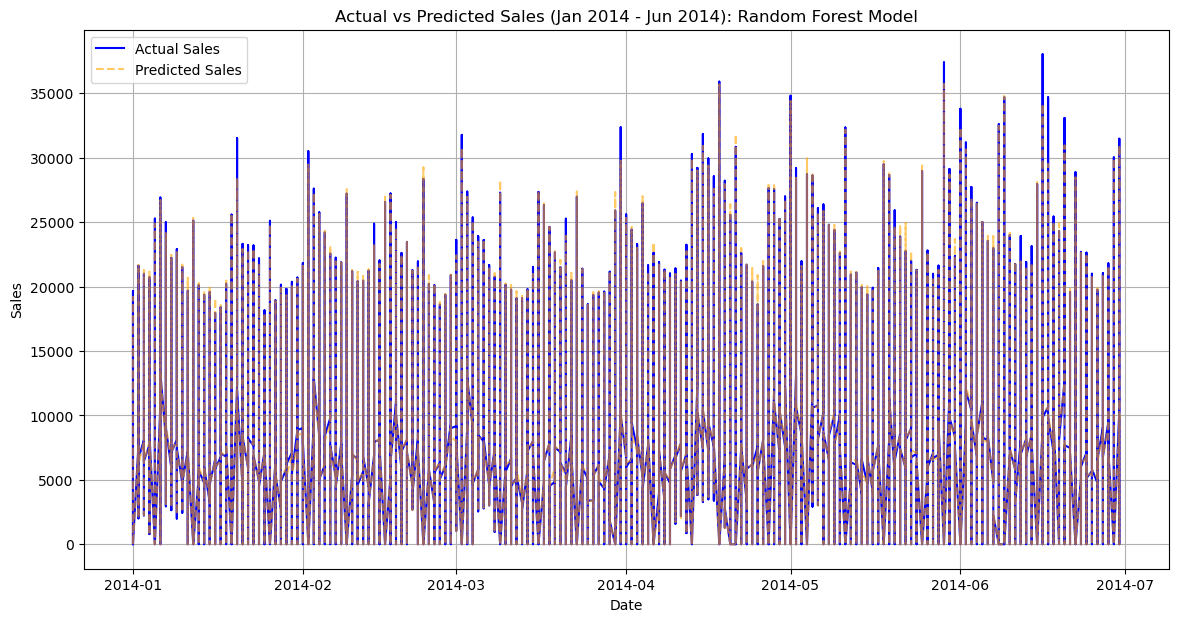

In [32]:
# Filter data for a specific date range (e.g., January to June 2014)
start_date = '2014-01-01'
end_date = '2014-06-30'

# Filter actual and predicted sales for the date range
filtered_daily_sales = daily_sales.loc[start_date:end_date]
filtered_predicted_sales = predicted_sales.loc[start_date:end_date]

# Visualize actual vs predicted sales within the specified date range
plt.figure(figsize=(14, 7))

# Plot actual sales in blue
plt.plot(filtered_daily_sales.index, filtered_daily_sales, label='Actual Sales', color='blue')

# Plot predicted sales in orange with transparency
plt.plot(filtered_predicted_sales.index, filtered_predicted_sales, label='Predicted Sales', linestyle='--', color='orange', alpha=0.6)

plt.title('Actual vs Predicted Sales (Jan 2014 - Jun 2014): Random Forest Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


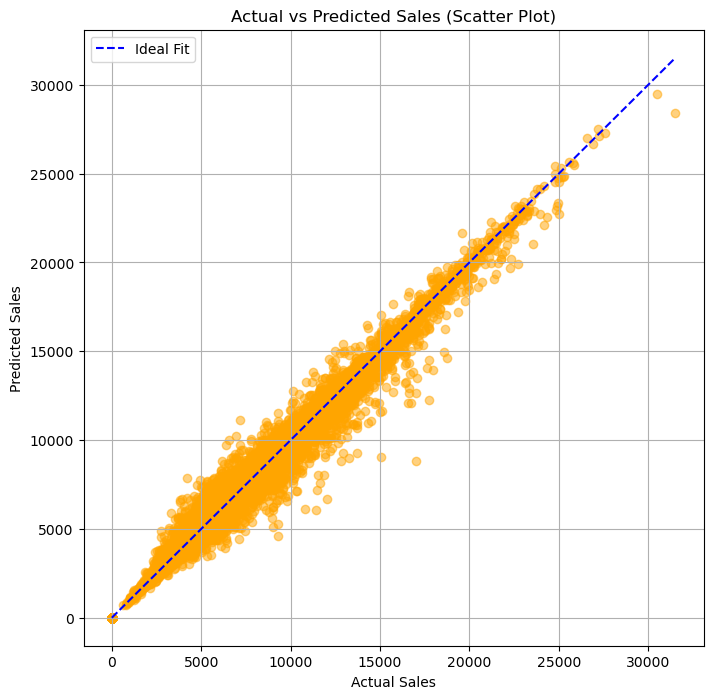

In [29]:
# Scatter plot of actual vs predicted sales
plt.figure(figsize=(8, 8))
plt.scatter(filtered_daily_sales, filtered_predicted_sales, alpha=0.5, color='orange')

# Plot a reference line (y = x) to show ideal predictions
plt.plot([filtered_daily_sales.min(), filtered_daily_sales.max()], 
         [filtered_daily_sales.min(), filtered_daily_sales.max()], 
         color='blue', linestyle='--', label='Ideal Fit')

plt.title('Actual vs Predicted Sales (Scatter Plot)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.legend()
plt.show()
